<a href="https://colab.research.google.com/github/anjaliii210/Cross-Market-Meta-Learner/blob/main/meta_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [18]:
# DOWNLOAD RAW DATA FRESH
assets = ['AAPL','MSFT','^GSPC','GC=F','SI=F','CL=F','EURUSD=X','GBPUSD=X','USDJPY=X']
data_raw = yf.download(assets, start='2015-01-01', end='2025-01-01')

# Flatten multiindex
data_raw.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data_raw.columns]

# Force daily calendar
data_raw.index = pd.to_datetime(data_raw.index)
full_index = pd.date_range(data_raw.index.min(), data_raw.index.max(), freq='D')
data_raw = data_raw.reindex(full_index).ffill().bfill()
data_raw.index.name = 'date'

#check
print("Raw shape:", data_raw.shape)
print("Sample columns:", data_raw.columns[:12])




/tmp/ipython-input-2329301870.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_raw = yf.download(assets, start='2015-01-01', end='2025-01-01')
[*********************100%***********************]  9 of 9 completed

Raw shape: (3653, 45)
Sample columns: Index(['Close_AAPL', 'Close_CL=F', 'Close_EURUSD=X', 'Close_GBPUSD=X',
       'Close_GC=F', 'Close_MSFT', 'Close_SI=F', 'Close_USDJPY=X',
       'Close_^GSPC', 'High_AAPL', 'High_CL=F', 'High_EURUSD=X'],
      dtype='object')


In [23]:
frames = []
for col in data_raw.columns:
    # expect format like "Close_AAPL" or "Open_GC=F"
    if '_' not in col:
        continue
    typ, ticker = col.split('_', 1)
    tmp = data_raw[[col]].reset_index().rename(columns={col: 'value'})
    tmp['type'] = typ
    tmp['ticker'] = ticker
    frames.append(tmp)

ohlc_long = pd.concat(frames, axis=0, ignore_index=True)
# pivot so we have columns Open/High/Low/Close/Volume per (date,ticker)
ohlc_pivot = ohlc_long.pivot_table(index=['date','ticker'], columns='type', values='value').reset_index()
# columns now: date, ticker, Close, High, Low, Open, Volume (if present)

# -------------------------
# 3) Create the price (Close) long table (this is the canonical per-asset series)
# -------------------------
df_price_long = ohlc_pivot[['date','ticker','Close']].rename(columns={'Close':'price'})
# asset_id consistent with earlier naming if you want: "Close_{ticker}"
df_price_long['asset_id'] = 'Close_' + df_price_long['ticker']

# sort & set index (not required but keeps order)
df_price_long = df_price_long.sort_values(['asset_id','date']).reset_index(drop=True)

# quick check
print("Assets (example):", df_price_long['asset_id'].unique()[:12])
print(df_price_long.head())

# -------------------------
# 4) Compute core features (per asset) - do this ONCE on raw price series
# -------------------------
def compute_core_features(df):
    # df must contain: date, ticker, asset_id, price sorted by asset_id & date
    out = df.copy()
    # raw percent return (price pct change per ticker)
    out['return'] = out.groupby('asset_id')['price'].pct_change()
    # rolling volatility (std of returns) with shift(1) to avoid future leakage
    out['vol_rolling'] = out.groupby('asset_id')['return'].transform(
        lambda s: s.rolling(20).std().shift(1)
    )
    # moving averages of price and expressed as deviation from price
    out['ma_5']  = out.groupby('asset_id')['price'].transform(lambda s: s.rolling(5).mean()) / out['price'] - 1
    out['ma_20'] = out.groupby('asset_id')['price'].transform(lambda s: s.rolling(20).mean()) / out['price'] - 1

    # vol-normalized return
    out['ret_volnorm'] = out['return'] / out['vol_rolling']

    # cumulative returns & drawdown
    out['cum'] = out.groupby('asset_id')['return'].transform(lambda s: (1 + s).cumprod())
    out['cum_max'] = out.groupby('asset_id')['cum'].cummax()
    out['drawdown'] = out['cum'] / out['cum_max'] - 1

    # short / long vol ratio (vol jump)
    out['vol_short'] = out.groupby('asset_id')['return'].transform(lambda s: s.rolling(5).std().shift(1))
    out['vol_long']  = out.groupby('asset_id')['return'].transform(lambda s: s.rolling(60).std().shift(1))
    out['vol_jump']  = out['vol_short'] / (out['vol_long'] + 1e-12)

    # VaR & CVaR (left tail) with shift(1)
    q = 0.05
    out['VaR'] = out.groupby('asset_id')['return'].transform(lambda s: s.shift(1).rolling(100).quantile(q))
    def rolling_cvar(x, q=q):
        if len(x)==0:
            return np.nan
        thr = np.nanpercentile(x, q*100)
        tail = x[x <= thr]
        return tail.mean() if len(tail)>0 else np.nan
    out['CVaR'] = out.groupby('asset_id')['return'].transform(lambda s: s.shift(1).rolling(100).apply(lambda x: rolling_cvar(x, q), raw=False))

    # lags and simple acf
    for lag in [1,2,5]:
        out[f'ret_lag_{lag}'] = out.groupby('asset_id')['return'].shift(lag)
    out['ret_var_20'] = out.groupby('asset_id')['return'].transform(lambda s: s.rolling(20).var().shift(1))
    out['acf1'] = out.groupby('asset_id')['return'].transform(
        lambda s: s.rolling(20).apply(lambda x: np.corrcoef(x[:-1], x[1:])[0,1] if len(x)>1 else np.nan).shift(1)
    )

    # next day target (label) - shift(-1) per asset
    out['target_next_day_return'] = out.groupby('asset_id')['return'].shift(-1)

    return out

df_features = compute_core_features(df_price_long)

def add_features(df):
    df = df.copy()

    # 1) Rolling Sharpe (return / vol) — short-term reward-to-risk
    df['roll_sharpe_20'] = df['return'] / df['vol_rolling']

    # 2) Rolling downside deviation (only negative returns)
    df['downside_dev_20'] = df.groupby('asset_id')['return'].transform(
        lambda s: s.rolling(20).apply(lambda x: np.sqrt(np.mean(np.minimum(x,0)**2))))

    # 3) Rolling skew (distribution shape)
    df['roll_skew_20'] = df.groupby('asset_id')['return'].transform(
        lambda s: s.rolling(20).skew())

    # 4) Rolling kurtosis (fat tails)
    df['roll_kurt_20'] = df.groupby('asset_id')['return'].transform(
        lambda s: s.rolling(20).kurt())

    # 5) Bollinger band zscore (price deviation from mean)
    df['boll_z'] = df.groupby('asset_id')['price'].transform(
        lambda s: (s - s.rolling(20).mean()) / s.rolling(20).std())

    # 6) ATR (Average True Range) — volatility of HIGH/LOW/PRICE
    df['ATR_14'] = (
        (df['High'] - df['Low']).abs()
        .groupby(df['asset_id']).transform(lambda x: x.rolling(14).mean())
    )

    # 7) RSI — momentum oscillator
    def rsi(series, period=14):
        delta = series.diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        ma_up = up.rolling(period).mean()
        ma_down = down.rolling(period).mean()
        return 100 - (100 / (1 + (ma_up / ma_down)))
    df['RSI_14'] = df.groupby('asset_id')['price'].transform(lambda s: rsi(s))

    # 8) Williams %R — trend exhaustion measure
    df['WilliamsR_14'] = df.groupby('asset_id').apply(
        lambda g: (g['High'].rolling(14).max() - g['price']) /
                  (g['High'].rolling(14).max() - g['Low'].rolling(14).min() + 1e-12),
        include_groups=False
    ).reset_index(level=0, drop=True)

    # 9) Realized volatility (sum of squared returns)
    df['realized_vol_20'] = df.groupby('asset_id')['return'].transform(
        lambda s: np.sqrt((s**2).rolling(20).sum()))

    # 10) Trend strength indicator (fraction of positive returns)
    df['trend_frac_20'] = df.groupby('asset_id')['return'].transform(
        lambda s: s.rolling(20).apply(lambda x: np.mean(x > 0)))

    return df

# -------------------------
# 5) Merge back same-asset OHLCV features (optional) — safe merge by ticker
# -------------------------
# pivoted ohlc_pivot has one row per (date,ticker)
# attach Open/High/Low/Volume as extra explanatory features (if needed)

# First, merge df_features with ohlc_pivot to include 'High', 'Low', 'Open', 'Volume'
df_merged_for_features = df_features.merge(ohlc_pivot, left_on=['date','ticker'], right_on=['date','ticker'], how='left')

# Now, call add_features on the DataFrame that contains all necessary columns
df_full = add_features(df_merged_for_features)

# drop duplicates or accidental mismatches
df_full = df_full.sort_values(['asset_id','date']).reset_index(drop=True)

Assets (example): ['Close_AAPL' 'Close_CL=F' 'Close_EURUSD=X' 'Close_GBPUSD=X' 'Close_GC=F'
 'Close_MSFT' 'Close_SI=F' 'Close_USDJPY=X' 'Close_^GSPC']
type       date ticker      price    asset_id
0    2015-01-01   AAPL  24.237556  Close_AAPL
1    2015-01-02   AAPL  24.237556  Close_AAPL
2    2015-01-03   AAPL  24.237556  Close_AAPL
3    2015-01-04   AAPL  24.237556  Close_AAPL
4    2015-01-05   AAPL  23.554739  Close_AAPL


/tmp/ipython-input-3069595585.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['WilliamsR_14'] = df.groupby('asset_id').apply(


In [26]:
# 6) Clean warm-up NaNs (drop rows that don't have complete history)
# -------------------------
# drop rows with NaN in key modeling columns (return, vol_rolling, target)
keep_cols = ['return','vol_rolling','ret_volnorm','target_next_day_return']
df_model = df_full.dropna(subset=keep_cols).reset_index(drop=True)

# -------------------------
# 7) Per-asset normalization (fit on training later; this is just z-scoring example now)
# -------------------------
cols_to_norm = ['return','vol_rolling','ma_5','ma_20','ret_volnorm','vol_jump','VaR','CVaR']
df_model[cols_to_norm] = df_model.groupby('asset_id')[cols_to_norm].transform(lambda x: (x - x.mean()) / x.std())

# -------------------------
# 8) Example controlled interactions (only hypothesis-driven pairs)
# -------------------------
pairs = [('ret_volnorm','vol_jump'), ('ret_lag_1','vol_rolling'), ('drawdown','ret_volnorm')]
for a,b in pairs:
    df_model[f'{a}_x_{b}'] = df_model[a] * df_model[b]

# -------------------------
# 9) Final checks / summary
# -------------------------
print("Final dataset shape:", df_model.shape)
print("Assets:", df_model['asset_id'].nunique())
print(
    df_model
    .sort_values(['asset_id','date'])
    [['asset_id','date','ticker','price','return','vol_rolling','ret_volnorm',
      'roll_sharpe_20','downside_dev_20','roll_skew_20','roll_kurt_20',
      'boll_z','ATR_14','RSI_14','WilliamsR_14',
      'realized_vol_20','trend_frac_20']]
    .groupby('asset_id')
    .head(3)
)



Final dataset shape: (32679, 41)
Assets: 9
type         asset_id       date    ticker        price    return  \
0          Close_AAPL 2015-01-22      AAPL    24.918146  1.697044   
1          Close_AAPL 2015-01-23      AAPL    25.046728  0.295990   
2          Close_AAPL 2015-01-24      AAPL    25.046728 -0.050670   
3631       Close_CL=F 2015-01-22      CL=F    46.310001 -0.501357   
3632       Close_CL=F 2015-01-23      CL=F    45.590000 -0.248230   
3633       Close_CL=F 2015-01-24      CL=F    45.590000  0.010367   
7262   Close_EURUSD=X 2015-01-22  EURUSD=X     1.161535  1.416461   
7263   Close_EURUSD=X 2015-01-23  EURUSD=X     1.134675 -5.506976   
7264   Close_EURUSD=X 2015-01-24  EURUSD=X     1.134675  0.004584   
10893  Close_GBPUSD=X 2015-01-22  GBPUSD=X     1.514486 -0.025777   
10894  Close_GBPUSD=X 2015-01-23  GBPUSD=X     1.501321 -1.745965   
10895  Close_GBPUSD=X 2015-01-24  GBPUSD=X     1.501321  0.007837   
14524      Close_GC=F 2015-01-22      GC=F  1300.699951  0.6

In [27]:
df_model = (
    df_full.groupby('asset_id')
           .apply(lambda g: g.iloc[40:])  # drop first ~40 warm-up rows
           .reset_index(drop=True)
)

/tmp/ipython-input-687455848.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.iloc[40:])  # drop first ~40 warm-up rows


In [28]:
df_model[['asset_id','date','price','return']].groupby('asset_id').head(10)

type,asset_id,date,price,return
0,Close_AAPL,2015-02-10,27.157578,0.019211
1,Close_AAPL,2015-02-11,27.794117,0.023439
2,Close_AAPL,2015-02-12,28.145775,0.012652
3,Close_AAPL,2015-02-13,28.283760,0.004903
4,Close_AAPL,2015-02-14,28.283760,0.000000
...,...,...,...,...
28909,Close_^GSPC,2015-02-15,2096.989990,0.000000
28910,Close_^GSPC,2015-02-16,2096.989990,0.000000
28911,Close_^GSPC,2015-02-17,2100.340088,0.001598
28912,Close_^GSPC,2015-02-18,2099.679932,-0.000314


In [30]:
from google.colab import drive
drive.mount('/content/drive')
df_model.to_parquet('/content/drive/MyDrive/df_model.parquet')
#for later
#df_model = pd.read_parquet('/content/drive/MyDrive/df_model.parquet')


Mounted at /content/drive


### Basic EDA

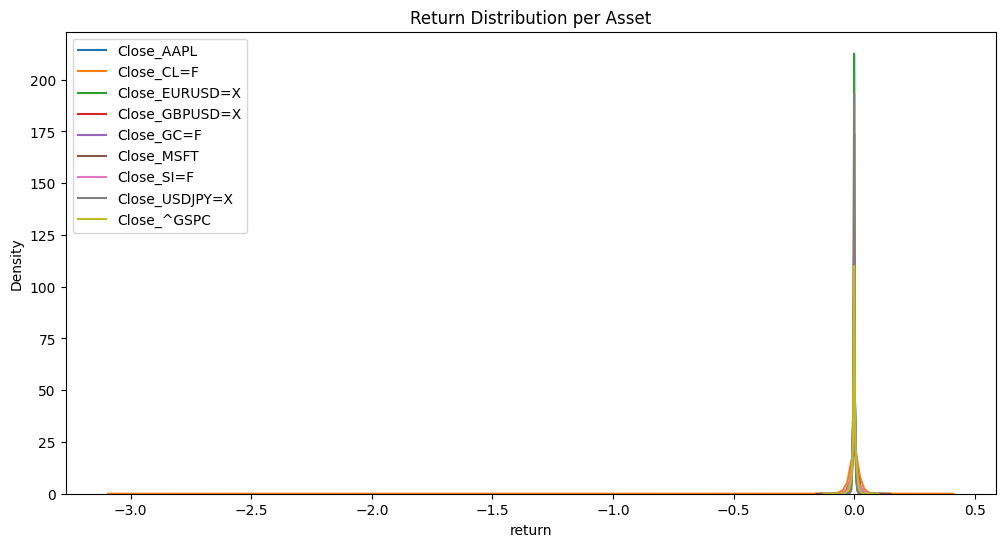

In [32]:
import seaborn as sns

plt.figure(figsize=(12,6))
for asset in df_model['asset_id'].unique():
    sns.kdeplot(df_model[df_model.asset_id==asset]['return'], label=asset)
plt.title("Return Distribution per Asset")
plt.legend()
plt.show()

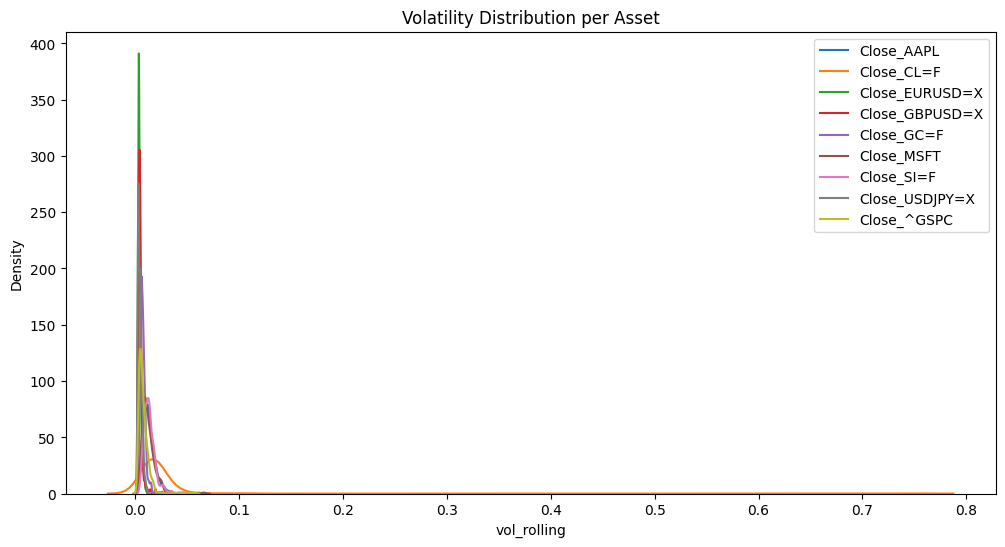

In [34]:
plt.figure(figsize=(12,6))
for asset in df_model['asset_id'].unique():
    sns.kdeplot(df_model[df_model.asset_id==asset]['vol_rolling'], label=asset)
plt.title("Volatility Distribution per Asset")
plt.legend()
plt.show()

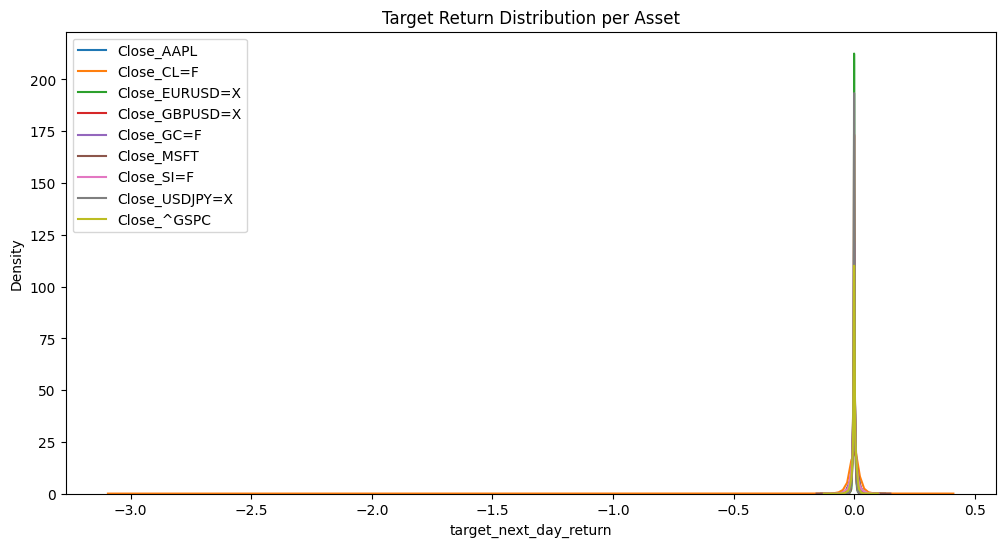

In [35]:
plt.figure(figsize=(12,6))
for asset in df_model['asset_id'].unique():
    sns.kdeplot(df_model[df_model.asset_id==asset]['target_next_day_return'], label=asset)
plt.title("Target Return Distribution per Asset")
plt.legend()
plt.show()

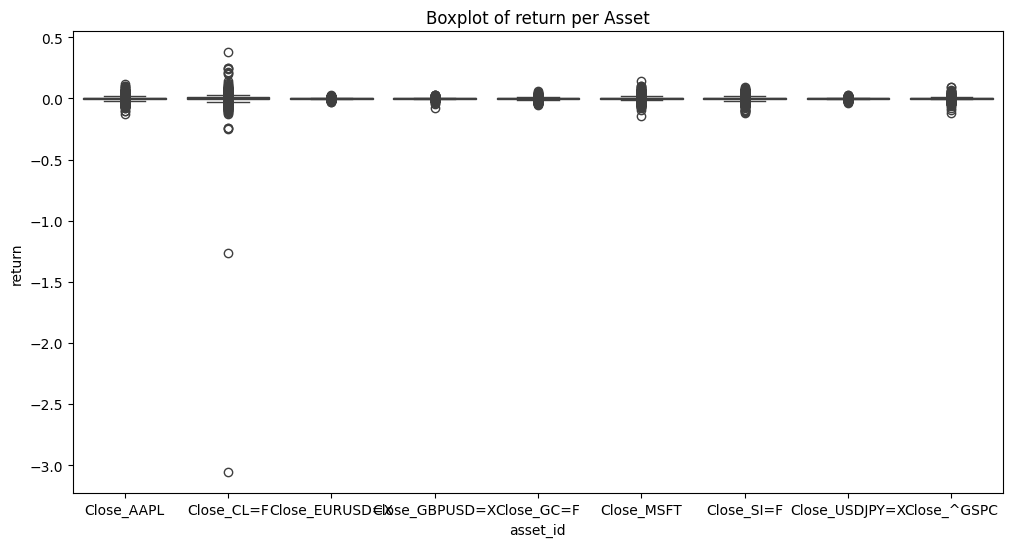

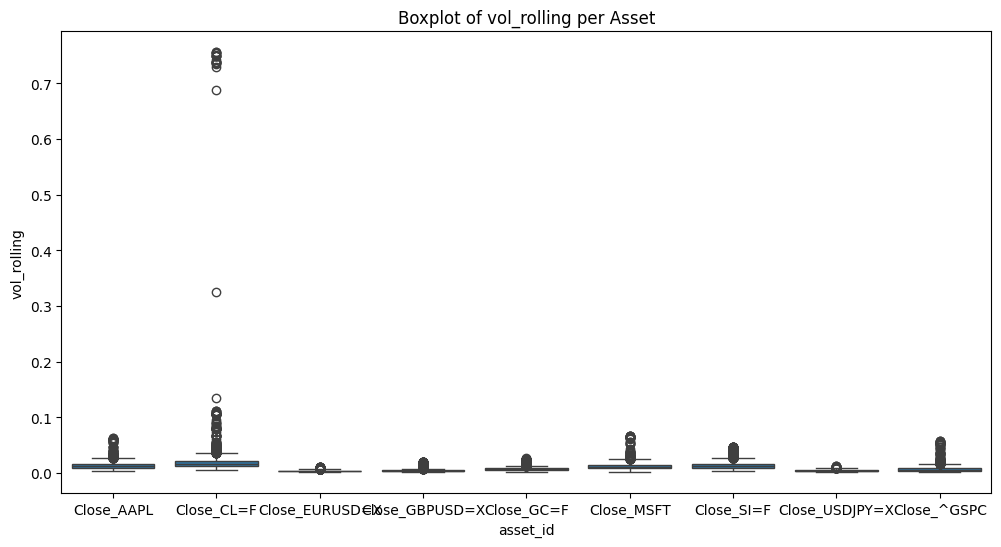

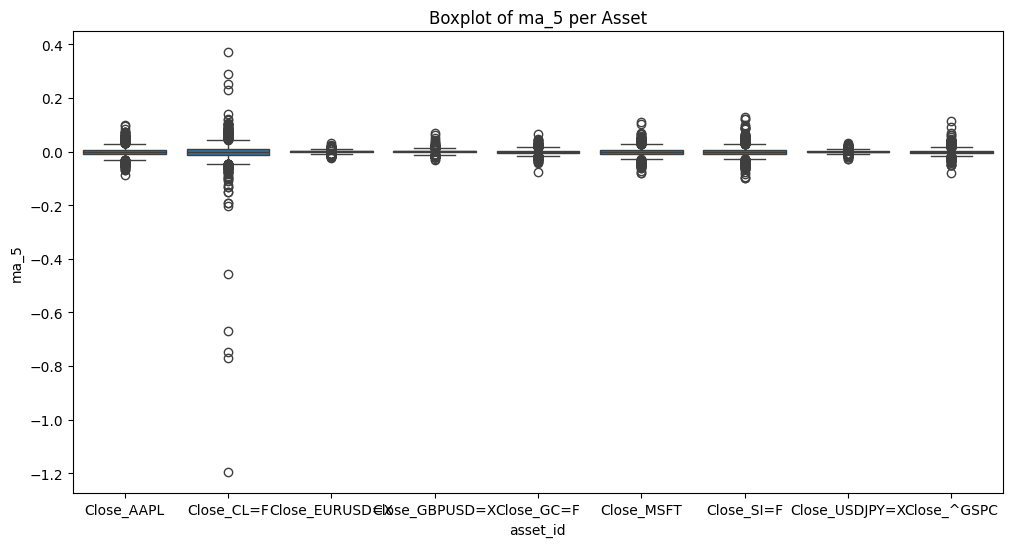

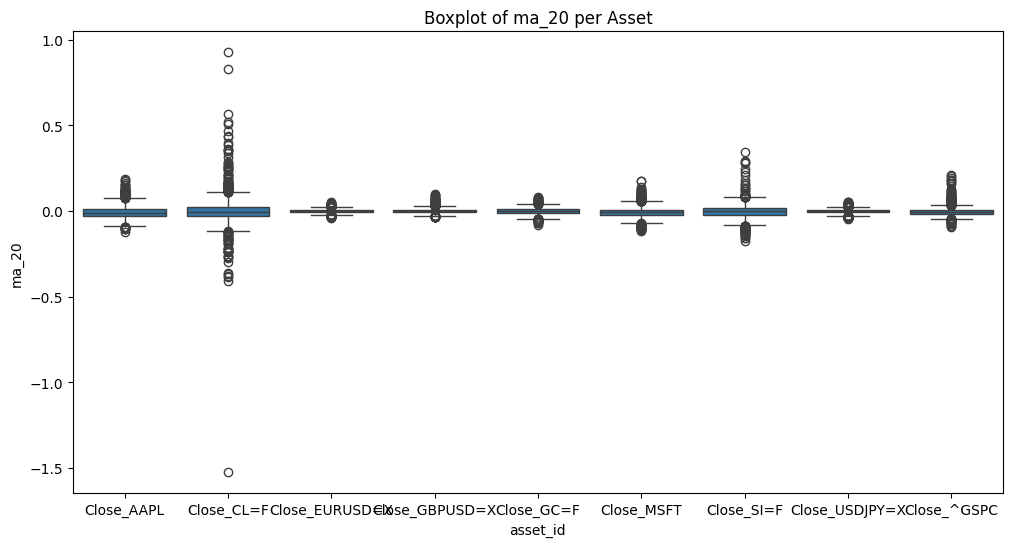

In [37]:
#boxplot per feature
features = ['return', 'vol_rolling', 'ma_5', 'ma_20']
for f in features:
    plt.figure(figsize=(12,6))
    sns.boxplot(x=df_model['asset_id'], y=df_model[f])
    plt.title(f"Boxplot of {f} per Asset")
    plt.show()